In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pylab as plt
import seaborn as sns
import ast
import glob


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Read Data

In [3]:
IMAGE_LOC = '../HMPDataset/'

In [4]:
activity_list = [i for i in glob.glob(f'{IMAGE_LOC}/*') if i.find('_') > 0 and "MODEL" not in i]

In [5]:
activity_list

['../HMPDataset/Walk_',
 '../HMPDataset/Use_telephone',
 '../HMPDataset/Eat_meat',
 '../HMPDataset/Drink_glass',
 '../HMPDataset/Climb_stairs',
 '../HMPDataset/Brush_teeth',
 '../HMPDataset/Eat_soup',
 '../HMPDataset/Sitdown_chair',
 '../HMPDataset/Liedown_bed',
 '../HMPDataset/Comb_hair',
 '../HMPDataset/Standup_chair',
 '../HMPDataset/Getup_bed',
 '../HMPDataset/Pour_water',
 '../HMPDataset/Descend_stairs']

In [6]:
def read_data(activity_list):
    '''Read files in each activity in activity_list
    Returns dict: key = activity name -> array of numpy arrays of shape (n_observations, 3) = (ax,ay,az)
    '''
    data = {}
    
    for t in activity_list: #loop over each activity type
        activity_name = t.split('/')[-1]
        data[activity_name] = []
    
        filenames = glob.glob(t + '/*')
        
        for f in filenames: #loop over every participants time-series
            df = pd.read_csv(f, sep=' ', header=None)
            
            #ts = np.sqrt((df**2).sum(axis=1)) #magnitude of acceleration vector
            
            data[activity_name].append(np.array(df))
    
    return data

def get_acceleration_timeseries(data):
    '''Input: data returned by read_data
    Output: dictionary mapping activity name -> list of single time-series of acceleration magnitudes
    '''
    
    data_ts = {}
    
    for k in data:
        data_ts[k] = []
        
        for sample in data[k]: #(ax, ay, az)
            data_ts[k].append(np.sqrt((sample**2).sum(axis=1)))
    
    return data_ts

def get_position_velocity(data):
    '''Input: data returned by read_data
    Output: dictionary mapping activity name -> list of displacement and speed time-series
    '''
    
    data_pos_vel = {}
    
    delta_time = 1 #time-step
    
    for k in data:
        data_pos_vel[k] = []
        
        for acc in data[k]:
            #x = x_0 + vt #constant velocity
            #v = u + at #constant acceleration
            #x = x_0 + ut + 1/2 at^2 #constant acceleration

            #discrete time - assume acceleration constant from step {t-1} to {t}
            #v_{t} = v_{t-1} + a_{t-1} t 
            #x_{t} = x_{t-1} + v_{t-1} t + 1/2 a_{t-1} t^2

            #set time t = 1 (unit). variable called delta_time
    
            #need to initialize p = (x,y,z), v = (vx, vy, vz)
            #assume initial position, velocity = 0
            
            pos, vel = np.zeros_like(acc), np.zeros_like(acc)
            
            for t in range(1, acc.shape[0]):
                vel[t] = vel[t-1] + acc[t-1] * delta_time
                
                pos[t] = pos[t-1] + vel[t-1]*delta_time + (1./2)*acc[t-1]*(delta_time**2)
                
                
            pos = np.sqrt((pos**2).sum(axis=1))
            vel = np.sqrt((vel**2).sum(axis=1))
            
            data_pos_vel[k].append((pos, vel))
            
    return data_pos_vel

In [7]:
data = read_data(activity_list)

In [8]:
data_ts = get_acceleration_timeseries(data)

In [9]:
data_pos_vel = get_position_velocity(data)

# Time-series plots

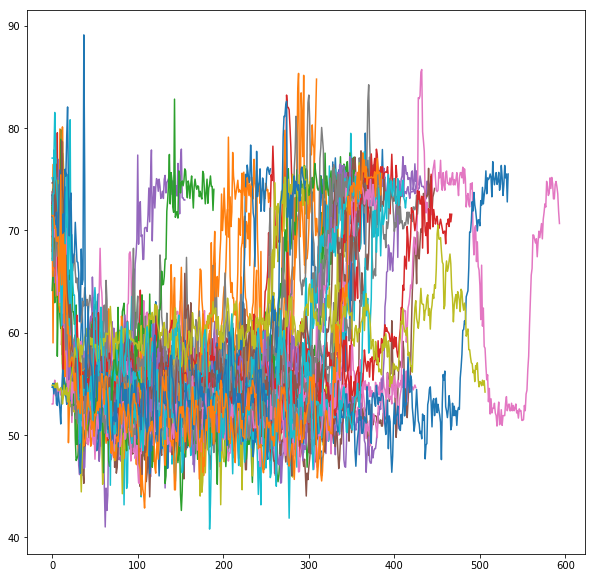

In [10]:
plt.figure(figsize=(10,10))
for elem in data_ts['Descend_stairs']:
    plt.plot(elem)

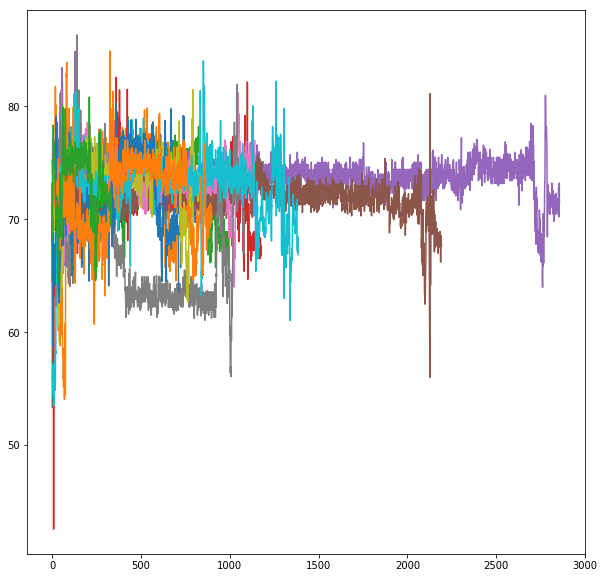

In [11]:
plt.figure(figsize=(10,10))
for elem in data_ts['Use_telephone']:
    plt.plot(elem)

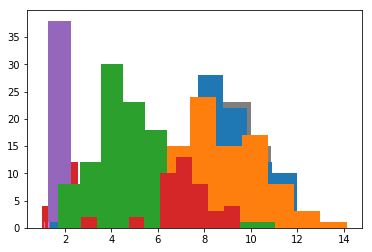

In [12]:
for k in data_ts:
    vols = []
    for val in data_ts[k]:
        vols.append(np.std(val))
        
    plt.hist(vols)

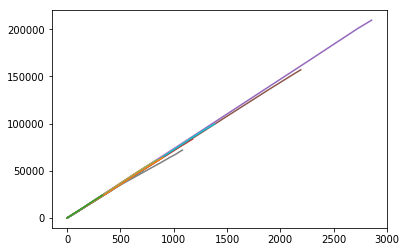

In [13]:
for elem in data_pos_vel['Use_telephone']:
    plt.plot(elem[1])
#for elem in data_pos_vel['Drink_glass']:
#    plt.plot(elem[1])    

In [14]:
#why no negative acc components?
for k in data:
    for elem in data[k]:
        if np.sum(elem < 0) > 0:
            print("Hello")

### Featurizer 1 - statistical properties of acceleration time-series

In [15]:
def featurize_stats(ts, bins):
    #basic statistical measures
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b,p = plt.hist(ts, bins=bins)
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    if median == 0: 
        features = {'mean_over_median': 0, #dimensionless            
                    'std_over_median': 0, #dimensionless            
                    'length': length,
                    'kurtosis': kurtosis, #already dimensionless by definition
                   }
        
    else: 
        features = {'mean_over_median': mean/median, #dimensionless            
            'std_over_median': std/median, #dimensionless            
            'length': length,
            'kurtosis': kurtosis, #already dimensionless by definition
           }
        
    for i, val in enumerate(n):
        features[f'binfrac_{i}'] = val
    
    return features

{'mean_over_median': 0.9988966796597712, 'std_over_median': 0.12426028344479251, 'length': 2346, 'kurtosis': 0.5544612021808502, 'binfrac_0': 0.0, 'binfrac_1': 0.0, 'binfrac_2': 0.0, 'binfrac_3': 0.0, 'binfrac_4': 0.0, 'binfrac_5': 0.0, 'binfrac_6': 0.0, 'binfrac_7': 0.00042625745950554135, 'binfrac_8': 0.002131287297527707, 'binfrac_9': 0.018329070758738276, 'binfrac_10': 0.09036658141517477, 'binfrac_11': 0.11082693947144075, 'binfrac_12': 0.22719522591645352, 'binfrac_13': 0.23572037510656438, 'binfrac_14': 0.2246376811594203, 'binfrac_15': 0.0494458653026428, 'binfrac_16': 0.017476555839727195, 'binfrac_17': 0.014919011082693947, 'binfrac_18': 0.008525149190110827}


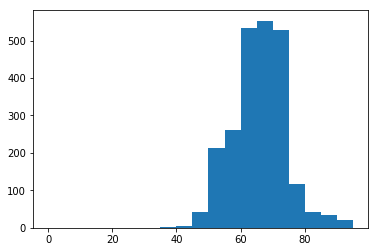

In [16]:
x = featurize_stats(data_ts['Brush_teeth'][0], np.arange(0,100,5))

print(x)

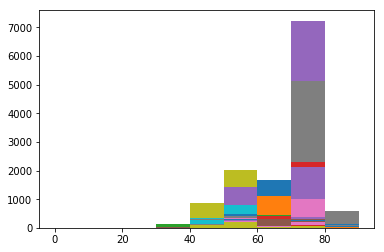

In [17]:
bins = np.arange(0,100,10)

df = []
labels = []

for k in data_ts: #slow, should parallelize
    for elem in data_ts[k]:
        df.append(featurize_stats(elem, bins))
        labels.append(k)

In [ ]:
df = pd.DataFrame(df)

In [ ]:
df['label'] = labels

In [ ]:
#dirty, sloppy model - no preprocessing, no train/test etc.
model = LogisticRegression()
model.fit(df.drop('label', axis=1), df['label'])

pred = model.predict(df.drop('label', axis=1))
labels = df['label']

print(np.sum(pred==labels) / len(pred)) #chosen at random, accuracy should be ~1/n_classes = 1/20 = 5%

In [ ]:
model = RandomForestClassifier()

model.fit(df.drop('label', axis=1), df['label'])

pred = model.predict(df.drop('label', axis=1))
labels = df['label']

print(np.sum(pred==labels) / len(pred)) #chosen at random, accuracy should be ~1/n_classes = 1/20 = 5%

In [ ]:
train_df, test_df = train_test_split(df, train_size=0.75)
print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

In [ ]:
def experiment(depth,estimators):
    model = RandomForestClassifier(max_depth=depth, n_estimators=estimators, n_jobs=10)

    model.fit(train_df.drop('label', axis=1), train_df['label'])

    train_pred = model.predict(train_df.drop('label', axis=1))
    train_labels = train_df['label']
    train_acc = np.sum(train_pred==train_labels) / len(train_pred)

    test_pred = model.predict(test_df.drop('label', axis=1))
    test_labels = test_df['label']
    test_acc = np.sum(test_pred==test_labels) / len(test_pred)

    print(f'max_depth={depth}, n_estimators={estimators}')
    print(f'train acc = {train_acc}, test_acc = {test_acc}')
    #return test_acc, train_acc, depth, estimators

In [ ]:
# Parameter tuning
depth = np.linspace(1,len(df.columns)-1,len(df.columns)-1)
estimators = (np.linspace(1,10,10,dtype=int))**2
for d in depth:
    for e in estimators:
        experiment(d,e)




In [ ]:
estimators

In [ ]:
len(df.columns)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot()

labels = list(train_df['label'].value_counts().index)

confusion = confusion_matrix(train_labels, train_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

### Featurizer 2 - scaled acceleration time-series

### Featurizer 3 - fourier transforms of raw acceleration time-series

In [ ]:
def convert_to_frequency(data_ts):
    list_of_actions = list(data_ts.keys()) 
    data_fq = dict()
    
    for action in list_of_actions:
        data_fq[action] = []
        for series in data_ts[action]:
            data_fq[action].append(np.fft.fft(series))
    
    return data_fq


In [ ]:
data_fq = convert_to_frequency(data_ts)

In [ ]:
plt.plot(data_fq["Brush_teeth"][0].imag)

In [ ]:
featurize_stats(data_fq["Brush_teeth"][0].real, np.arange(0,100,10))

In [ ]:
featurize_stats(data_fq["Walk_"][0].real, np.arange(0,100,10))

In [ ]:
bins = np.arange(0,100,10)

df = []
labels = []

for k in data_fq: #slow, should parallelize
    for elem in data_fq[k]:
        df.append(featurize_stats(elem.real, bins))
        labels.append(k)

In [ ]:
df = pd.DataFrame(df)

In [ ]:
df['label'] = labels

In [ ]:
train_df, test_df = train_test_split(df, train_size=0.75)
print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

In [ ]:
model = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=10)

model.fit(train_df.drop('label', axis=1), train_df['label'])

train_pred = model.predict(train_df.drop('label', axis=1))
train_labels = train_df['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_df.drop('label', axis=1))
test_labels = test_df['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

In [ ]:
bins = np.arange(0,100,10)

df = []
labels = []

for k in data_fq: #slow, should parallelize
    for elem in data_fq[k]:
        df.append(featurize_stats(elem.imag, bins))
        labels.append(k)

In [ ]:
df = pd.DataFrame(df)
df['label'] = labels

In [ ]:
train_df, test_df = train_test_split(df, train_size=0.75)
print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

In [ ]:
model = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=10)

model.fit(train_df.drop('label', axis=1), train_df['label'])

train_pred = model.predict(train_df.drop('label', axis=1))
train_labels = train_df['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_df.drop('label', axis=1))
test_labels = test_df['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

### Featurizer 3 - velocity vs position plots

In [ ]:
?plt.hist

### tensorflow

In [ ]:
# Load libraries
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers

# Set random seed
np.random.seed(0)

In [ ]:
train_df['label'].

In [ ]:
one_hot = np.array(train_df['label'])
label_encoder = LabelEncoder()
integer_encoder = label_encoder.fit_transform(one_hot)
#print(integer_encoder)
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoder = integer_encoder.reshape(len(integer_encoder),1)
train_label = one_hot_encoder.fit_transform(integer_encoder)


In [ ]:
one_hot = np.array(test_df['label'])
label_encoder = LabelEncoder()
integer_encoder = label_encoder.fit_transform(one_hot)
#print(integer_encoder)
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoder = integer_encoder.reshape(len(integer_encoder),1)
test_label = one_hot_encoder.fit_transform(integer_encoder)


In [ ]:
number_of_features = 13

network = models.Sequential()
network.add(layers.Dense(units=10, activation='relu', input_shape=(number_of_features,)))
network.add(layers.Dense(units=14, activation='softmax'))

network.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

history = network.fit(train_df.drop('label', axis=1), # Features
                      train_label, # Target vector
                      epochs=2000, # Three epochs
                      verbose=1, # No output
                      batch_size=100, # Number of observations per batch
                      validation_data=(test_df.drop('label', axis=1), test_label)) # Data to use for evaluation

plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [ ]:
# Bad Model

number_of_features = 13

network = models.Sequential()
network.add(layers.Dense(units=156, activation='relu', input_shape=(number_of_features,)))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=56, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=56, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=56, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=56, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=28, activation='relu'))
network.add(layers.Dense(units=14, activation='softmax'))

network.compile(loss='categorical_crossentropy',
               optimizer='rmsprop',
               metrics=['accuracy'])

history = network.fit(train_df.drop('label', axis=1), # Features
                      train_label, # Target vector
                      epochs=10000, # Three epochs
                      verbose=0, # No output
                      batch_size=200, # Number of observations per batch
                      validation_data=(test_df.drop('label', axis=1), test_label)) # Data to use for evaluation

plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [ ]:
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'train_loss' )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [ ]:
network.summary()